# Single-cell RNA Sequencing of human scalp: Analysis

Data Source Acknowledgment: The dataset is sourced from [GSE212450](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE212450). This notebook uses sub-dataset which comprises single-cell RNA sequencing data from human scalp with alopecia areata (GSM6532922	AA8_scRNA) and control (GSM6532927	C_SD2_scRNA).

Reference: Ober-Reynolds B, Wang C, Ko JM, Rios EJ et al. Integrated single-cell chromatin and transcriptomic analyses of human scalp identify gene-regulatory programs and critical cell types for hair and skin diseases. Nat Genet 2023 Aug;55(8):1288-1300. PMID: 37500727

It's essential to emphasize that this dataset is exclusively utilized for Python practice purposes within this repository. This notebook will use this dataset to practice data cleaning techniques and clustering.

In [1]:
#using SCanalysis environment
import numpy as np
import pandas as pd
import seaborn as  sns
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import anndata as ad

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)

In [54]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=160,
    facecolor="white",
    frameon=False,)

In [5]:
adata = sc.read_h5ad('annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 6699 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

## 1. Compositional analysis

1.1 Calculate the frequency of each cell types in case and control group

In [24]:
total_cells = adata.obs.groupby(['sample']).count()

In [25]:
total_cells = dict(zip(total_cells.index, total_cells.doublet))

In [26]:
total_cells

{'case': 4809, 'control': 1890}

In [34]:
cell_type_count = adata.obs.groupby(['sample', 'manual_label']).count()

In [35]:
cell_type_count

n_genes_by_counts  log1p_n_genes_by_counts  \
sample  manual_label                                                        
case    CD4+T                               1821                     1821   
        CD8+T                                751                      751   
        HFDPC                                 52                       52   
        HF_keratinocyte                       12                       12   
        M1_macrophage                         29                       29   
        Treg                                 391                      391   
        basal_keratinocyte                   115                      115   
        dendritic_cell                       145                      145   
        dermal_fibroblast                    332                      332   
        dermal_sheath                        127                      127   
        lymphatic_endothelium                 40                       40   
        macrophage                           164                      164   
        mast_cell                             75                       75   
        melanocyte                            70                       70   
        myocyte                              261                      261   
        pericyte                              58                       58   
        plasma_cell                           54                       54   
        spinous_keratinocyte                 116                      116   
        vascular_endothelium                 196                      196   
control CD4+T                                108                      108   
        CD8+T                                 42                       42   
        HFDPC                                 54                       54   
        HF_keratinocyte                       73                       73   
        M1_macrophage                         12                       12   
        Treg                                  40                       40   
        basal_keratinocyte                    38                       38   
        dendritic_cell                        84                       84   
        dermal_fibroblast                    420                      420   
        dermal_sheath                         24                       24   
        lymphatic_endothelium                 16                       16   
        macrophage                           194                      194   
        mast_cell                            183                      183   
        melanocyte                            49                       49   
        myocyte                              106                      106   
        pericyte                              39                       39   
        plasma_cell                            3                        3   
        spinous_keratinocyte                 282                      282   
        vascular_endothelium                 123                      123   

                               total_counts  log1p_total_counts  \
sample  manual_label                                              
case    CD4+T                          1821                1821   
        CD8+T                           751                 751   
        HFDPC                            52                  52   
        HF_keratinocyte                  12                  12   
        M1_macrophage                    29                  29   
        Treg                            391                 391   
        basal_keratinocyte              115                 115   
        dendritic_cell                  145                 145   
        dermal_fibroblast               332                 332   
        dermal_sheath                   127                 127   
        lymphatic_endothelium            40                  40   
        macrophage                      164                 164   
        mast

In [39]:
#get rid of zero row and break these 2 index down into only 1 index
cell_type_count = cell_type_count[cell_type_count.sum(axis = 1) > 0].reset_index()
cell_type_count

,sample,manual_label,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,doublet,celltypist_skin_label,celltypist_conf_score,_scvi_batch,_scvi_labels,overcluster,celltypist_skin_major
0,case,CD4+T,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821
1,case,CD8+T,751,751,751,751,751,751,751,751,751,751,751,751,751,751,751
2,case,HFDPC,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52
3,case,HF_keratinocyte,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
4,case,M1_macrophage,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
5,case,Treg,391,391,391,391,391,391,391,391,391,391,391,391,391,391,391
6,case,basal_keratinocyte,115,115,115,115,115,115,115,115,115,115,115,115,115,115,115
7,case,dendritic_cell,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145
8,case,dermal_fibroblast,332,332,332,332,332,332,332,332,332,332,332,332,332,332,332
9,case,dermal_sheath,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127


In [41]:
cell_type_count = cell_type_count[['sample', 'manual_label', 'doublet']]
cell_type_count

,sample,manual_label,doublet
0,case,CD4+T,1821
1,case,CD8+T,751
2,case,HFDPC,52
3,case,HF_keratinocyte,12
4,case,M1_macrophage,29
5,case,Treg,391
6,case,basal_keratinocyte,115
7,case,dendritic_cell,145
8,case,dermal_fibroblast,332
9,case,dermal_sheath,127


In [42]:
#add total cell of each sample in the new column
cell_type_count['total_cells'] = cell_type_count['sample'].map(total_cells)
cell_type_count

,sample,manual_label,doublet,total_cells
0,case,CD4+T,1821,4809
1,case,CD8+T,751,4809
2,case,HFDPC,52,4809
3,case,HF_keratinocyte,12,4809
4,case,M1_macrophage,29,4809
5,case,Treg,391,4809
6,case,basal_keratinocyte,115,4809
7,case,dendritic_cell,145,4809
8,case,dermal_fibroblast,332,4809
9,case,dermal_sheath,127,4809


In [43]:
cell_type_count.dtypes

sample          category
manual_label    category
doublet            int64
total_cells     category
dtype: object

In [44]:
cell_type_count['total_cells'] = cell_type_count['total_cells'].astype(int)
cell_type_count['frequency'] = cell_type_count.doublet / cell_type_count.total_cells
cell_type_count

,sample,manual_label,doublet,total_cells,frequency
0,case,CD4+T,1821,4809,0.378665
1,case,CD8+T,751,4809,0.156166
2,case,HFDPC,52,4809,0.010813
3,case,HF_keratinocyte,12,4809,0.002495
4,case,M1_macrophage,29,4809,0.006030
5,case,Treg,391,4809,0.081306
6,case,basal_keratinocyte,115,4809,0.023913
7,case,dendritic_cell,145,4809,0.030152
8,case,dermal_fibroblast,332,4809,0.069037
9,case,dermal_sheath,127,4809,0.026409


In [47]:
#create stack bar plot of each samples
cell_types = cell_type_count['manual_label'].unique()
df_grouped = cell_type_count.groupby(['sample', 'manual_label'])['frequency'].sum().unstack()
df_grouped = df_grouped.reset_index()
df_grouped

manual_label,sample,CD4+T,CD8+T,HFDPC,HF_keratinocyte,M1_macrophage,Treg,basal_keratinocyte,dendritic_cell,dermal_fibroblast,dermal_sheath,lymphatic_endothelium,macrophage,mast_cell,melanocyte,myocyte,pericyte,plasma_cell,spinous_keratinocyte,vascular_endothelium
0,case,0.378665,0.156166,0.010813,0.002495,0.006030,0.081306,0.023913,0.030152,0.069037,0.026409,0.008318,0.034103,0.015596,0.014556,0.054273,0.012061,0.011229,0.024121,0.040757
1,control,0.057143,0.022222,0.028571,0.038624,0.006349,0.021164,0.020106,0.044444,0.222222,0.012698,0.008466,0.102646,0.096825,0.025926,0.056085,0.020635,0.001587,0.149206,0.065079


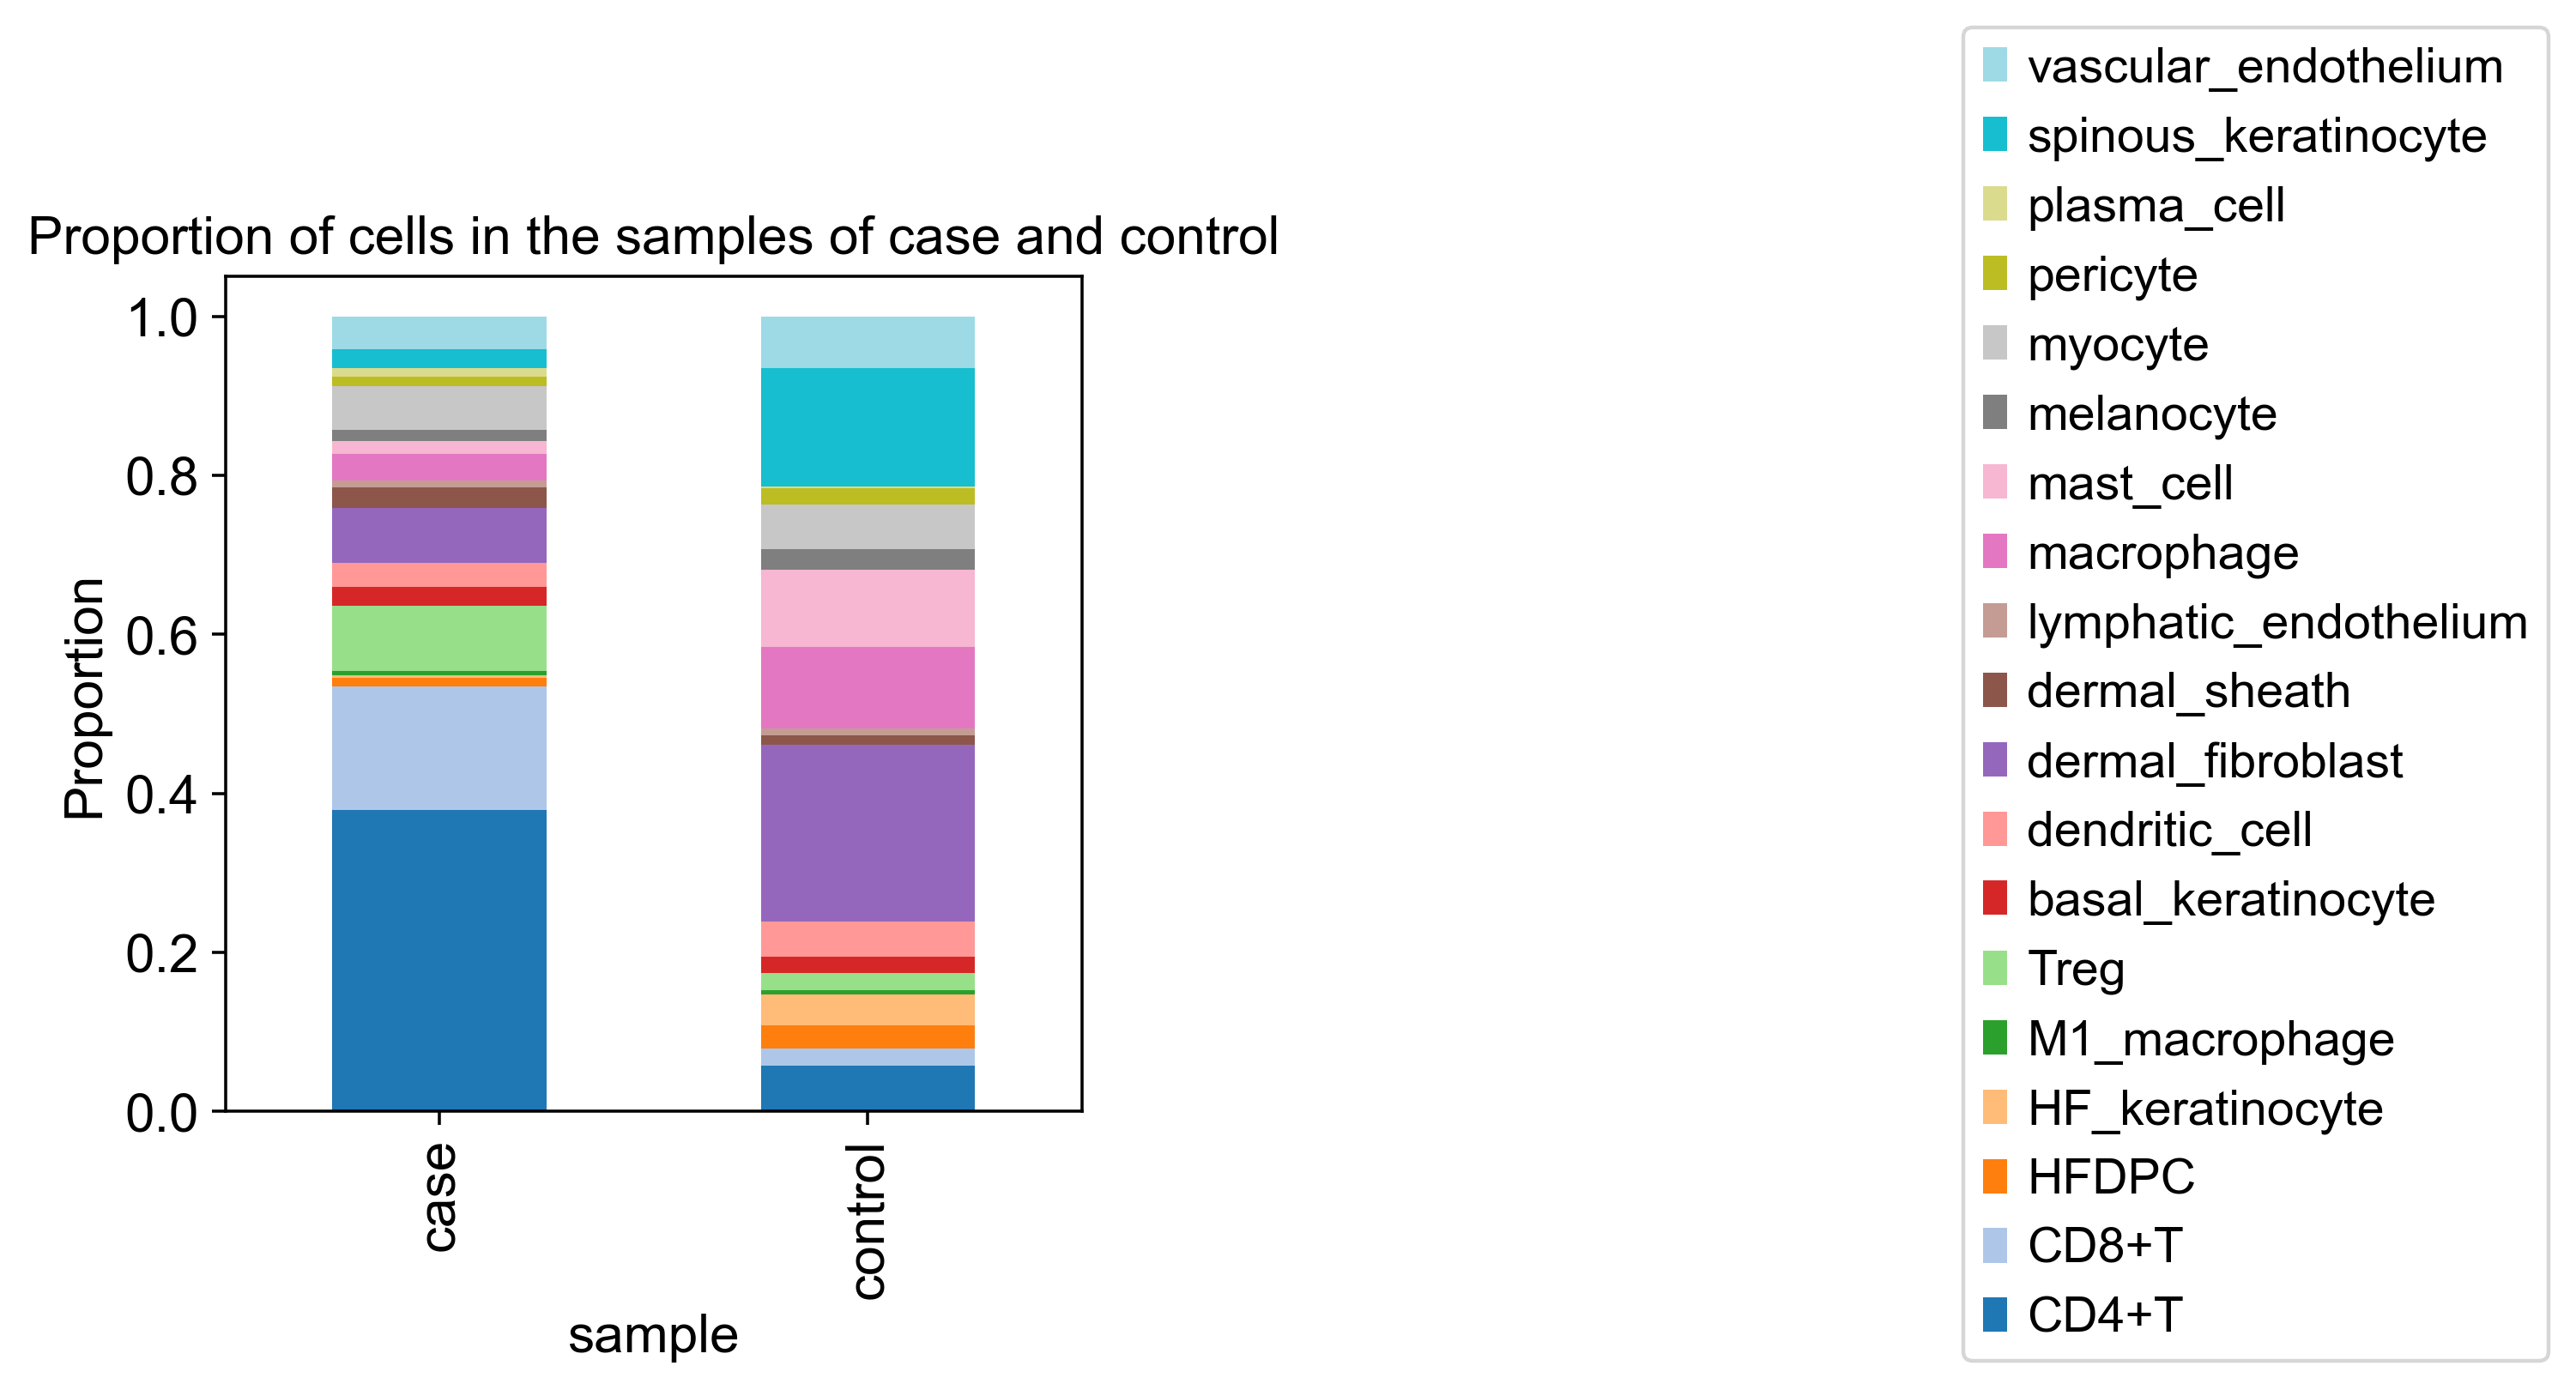

In [55]:
ax = df_grouped.plot(x='sample', kind='bar', stacked=True, colormap='tab20')
plt.legend(loc='center left', bbox_to_anchor=(2, 0.5), reverse=True)
plt.ylabel('Proportion')
plt.title('Proportion of cells in the samples of case and control')
# Remove grid lines
ax.grid(False)
plt.show()

In [68]:
cell_type_count_eachType = adata.obs.groupby(['manual_label']).count()

In [69]:
cell_type_count_eachType

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,doublet,sample,celltypist_skin_label,celltypist_conf_score,_scvi_batch,_scvi_labels,overcluster,celltypist_skin_major
manual_label,,,,,,,,,,,,,,,,
CD4+T,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929,1929
CD8+T,793,793,793,793,793,793,793,793,793,793,793,793,793,793,793,793
HFDPC,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106
HF_keratinocyte,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85
M1_macrophage,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41
Treg,431,431,431,431,431,431,431,431,431,431,431,431,431,431,431,431
basal_keratinocyte,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153
dendritic_cell,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229
dermal_fibroblast,752,752,752,752,752,752,752,752,752,752,752,752,752,752,752,752


In [70]:
total_cell_eachType = dict(zip(cell_type_count_eachType.index, cell_type_count_eachType.doublet))

In [76]:
total_cell_eachType 

{'CD4+T': 1929,
 'CD8+T': 793,
 'HFDPC': 106,
 'HF_keratinocyte': 85,
 'M1_macrophage': 41,
 'Treg': 431,
 'basal_keratinocyte': 153,
 'dendritic_cell': 229,
 'dermal_fibroblast': 752,
 'dermal_sheath': 151,
 'lymphatic_endothelium': 56,
 'macrophage': 358,
 'mast_cell': 258,
 'melanocyte': 119,
 'myocyte': 367,
 'pericyte': 97,
 'plasma_cell': 57,
 'spinous_keratinocyte': 398,
 'vascular_endothelium': 319}

In [84]:
cell_type_count['total_cells_eachType'] = cell_type_count['manual_label'].map(total_cell_eachType)

In [86]:
cell_type_count

,sample,manual_label,doublet,total_cells,frequency,total_cells_eachType
0,case,CD4+T,1821,4809,0.378665,1929
1,case,CD8+T,751,4809,0.156166,793
2,case,HFDPC,52,4809,0.010813,106
3,case,HF_keratinocyte,12,4809,0.002495,85
4,case,M1_macrophage,29,4809,0.006030,41
5,case,Treg,391,4809,0.081306,431
6,case,basal_keratinocyte,115,4809,0.023913,153
7,case,dendritic_cell,145,4809,0.030152,229
8,case,dermal_fibroblast,332,4809,0.069037,752
9,case,dermal_sheath,127,4809,0.026409,151


In [88]:
cell_type_count['total_cells_eachType'] = cell_type_count['total_cells_eachType'].astype(int)
cell_type_count['frequency_eachType'] = cell_type_count.doublet / cell_type_count.total_cells_eachType
cell_type_count

,sample,manual_label,doublet,total_cells,frequency,total_cells_eachType,frequency_eachType
0,case,CD4+T,1821,4809,0.378665,1929,0.944012
1,case,CD8+T,751,4809,0.156166,793,0.947037
2,case,HFDPC,52,4809,0.010813,106,0.490566
3,case,HF_keratinocyte,12,4809,0.002495,85,0.141176
4,case,M1_macrophage,29,4809,0.006030,41,0.707317
5,case,Treg,391,4809,0.081306,431,0.907193
6,case,basal_keratinocyte,115,4809,0.023913,153,0.751634
7,case,dendritic_cell,145,4809,0.030152,229,0.633188
8,case,dermal_fibroblast,332,4809,0.069037,752,0.441489
9,case,dermal_sheath,127,4809,0.026409,151,0.841060


In [97]:
#create stack bar plot of each samples
cell_types = cell_type_count['manual_label'].unique()
df_grouped = cell_type_count.groupby(['sample', 'manual_label'])['frequency_eachType'].sum().unstack()
df_grouped = df_grouped.reset_index()
df_grouped = df_grouped.T
df_grouped = df_grouped.reset_index()
df_grouped

,manual_label,0,1
0,sample,case,control
1,CD4+T,0.944012,0.055988
2,CD8+T,0.947037,0.052963
3,HFDPC,0.490566,0.509434
4,HF_keratinocyte,0.141176,0.858824
5,M1_macrophage,0.707317,0.292683
6,Treg,0.907193,0.092807
7,basal_keratinocyte,0.751634,0.248366
8,dendritic_cell,0.633188,0.366812
9,dermal_fibroblast,0.441489,0.558511


In [98]:
ax = df_grouped.plot(x='manual_label', kind='bar', stacked=True, colormap='tab20')
plt.legend(loc='center left', bbox_to_anchor=(2, 0.5), reverse=True)
plt.ylabel('Proportion')
plt.title('Proportion of cells in the samples of case and control')
# Remove grid lines
ax.grid(False)
plt.show()

TypeError: no numeric data to plot